In [ ]:
!pip install sentencepiece -q
!pip install transformers  -q

     |████████████████████████████████| 1.2 MB 3.6 MB/s 
     |████████████████████████████████| 4.0 MB 5.6 MB/s 
     |████████████████████████████████| 6.6 MB 18.8 MB/s 
     |████████████████████████████████| 895 kB 46.7 MB/s 
     |████████████████████████████████| 596 kB 44.4 MB/s 
     |████████████████████████████████| 77 kB 3.9 MB/s 


In [ ]:
!git clone "https://github.com/anoopkunchukuttan/indic_nlp_library" -q
!git clone https://github.com/anoopkunchukuttan/indic_nlp_resources.git -q
!pip install Morfessor -q
# The path to the local git repo for Indic NLP library
INDIC_NLP_LIB_HOME=r"/content/indic_nlp_library" 

# The path to the local git repo for Indic NLP Resources
INDIC_NLP_RESOURCES="/content/indic_nlp_resources" 

In [ ]:
import sys
sys.path.append(r'{}'.format(INDIC_NLP_LIB_HOME))
from indicnlp import common
common.set_resources_path(INDIC_NLP_RESOURCES)
from indicnlp import loader

In [ ]:
from indicnlp.tokenize import indic_tokenize

In [ ]:
import torch
import numpy as np
import pandas as pd
import re
from transformers import AutoModel, AutoTokenizer
import pickle
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score

In [ ]:
!unzip CorpusDicts.zip

Archive:  CorpusDicts.zip
  inflating: banglaDict.pkl          
  inflating: banglaDictNoStopwords.pkl  
  inflating: hindiDict.pkl           
  inflating: hindiDictNoStopwords.pkl  
  inflating: tamilDict.pkl           
  inflating: tamilDictNoStopwords.pkl  


In [ ]:
dataframe=pd.read_csv('hindi-train.csv',sep='\t',names=['cat','text'],header=None)

In [ ]:
dataframe= dataframe.dropna()

In [ ]:
Cat = pd.factorize(dataframe['cat'])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip 'drive/MyDrive/IR_Project/New_embeddings.zip'

Archive:  drive/MyDrive/IR_Project/New_embeddings.zip
  inflating: doc2vec_ban (1).pkl     
  inflating: indic_hi (1).pkl        
  inflating: muril_hi (1).pkl        
  inflating: indic_ban (1).pkl       
  inflating: indic_tam (1).pkl       
  inflating: muril_tam (1).pkl       
  inflating: muril_ban (1).pkl       
  inflating: doc2vec_tam (1).pkl     
  inflating: doc2vec_hi (1).pkl      


In [ ]:
data={}
doc_id=0
for category,text in zip(dataframe['cat'].values,dataframe['text'].values):
    data[doc_id]={}
    data[doc_id]['text']=text
    data[doc_id]['category']=category
    doc_id+=1

In [ ]:
dataset = []
for key,value in hi_dataset.items():
  #print(type(value['text']))
  dataset.append(value['text'])

In [ ]:
def evaluate(predictions,embeddings,true_labels):
  predicted_labels = predictions
  
  random_DV = embeddings
  labels = predicted_labels
  rand_score=metrics.rand_score(true_labels, predicted_labels)
  mutual_score=metrics.mutual_info_score(true_labels, predicted_labels)
  homo_score=metrics.homogeneity_score(true_labels, predicted_labels)
  complete_score=metrics.completeness_score(true_labels, predicted_labels)
  v_score=metrics.v_measure_score(true_labels, predicted_labels)
  fm_score=metrics.fowlkes_mallows_score(true_labels, predicted_labels)
  silhoutte_score=metrics.silhouette_score(random_DV, predicted_labels, metric='euclidean')
  calinski_score=metrics.calinski_harabasz_score(random_DV, predicted_labels)
  davies_score=davies_bouldin_score(random_DV, labels)
  #print('---IndicBert Score-----')
  print("rand_Score: ", rand_score)
  print("mutual_score: ",mutual_score)
  print("homo_score: ",homo_score)
  print("completeness_score: ",complete_score)
  print("V-score: ",v_score)
  print("fowlkes mallows: ",fm_score)
  print("silhoutte score: ",silhoutte_score)
  print("calinski_score: ",calinski_score)
  print("davies score: ",davies_score)

## Doc2Vec Implementation:  call D2V(data,lang), returns list of embeddings

In [ ]:
def D2V(data,lang):

  try:
    with open('doc2vec_'+str(lang)+'.pkl','rb') as f:
      dataset = pickle.load(f)
    return dataset
  except:
    dataset = []
    for key,value in data.items():
      #print(type(value['text']))
      dataset.append(value['text'])
    
    Data = [indic_tokenize.trivial_tokenize(d) for d in dataset]

    def tagged_document(list_of_list_of_words):
      for i, list_of_words in enumerate(list_of_list_of_words):
          yield TaggedDocument(list_of_words, [i])
    data_for_training = list(tagged_document(Data))

    model = Doc2Vec(vector_size=300, min_count=2, epochs=50)

    model.build_vocab(data_for_training)

    model.train(data_for_training, total_examples=model.corpus_count, epochs=model.epochs)

    d2v_dataset=[]
    for d in Data:
      d2v_dataset.append(model.infer_vector(d))

    with open('doc2vec_'+str(lang)+'.pkl', 'wb') as f:
      pickle.dump(d2v_dataset,f)

    

    return d2v_dataset

### MurilBert Embedding

In [ ]:
def MurilBert(data,lang):
  path = 'google/muril-base-cased'
  ## Loading the model
  try:
    with open('muril_'+lang+'.pkl','rb') as f:
      embeddings = pickle.load(f)
    
  except:

    tokenizer = AutoTokenizer.from_pretrained(path)
    model = AutoModel.from_pretrained(path,output_hidden_states=True)

    embeddings=[]
    dataset = []
    for key,value in data.items():
      #print(type(value['text']))
      dataset.append(value['text'])
      
    for text in dataset:
      
      #print(tokenizer.convert_ids_to_tokens(tokenizer.encode(text)))
      input_encoded = tokenizer.encode_plus(text,truncation=True,max_length=512,return_tensors="pt")
      #print(input_encoded)
      with torch.no_grad():
        states = model(**input_encoded).hidden_states
      output = torch.stack([states[i] for i in range(len(states))])
      output = output.squeeze()
      #print("Output shape is {}".format(output.shape))
      res = output.mean(axis=0)
      embed = res.mean(axis=0)
      embed = embed.squeeze()
      embeddings.append(embed)

    with open('muril_'+str(lang)+'.pkl', 'wb') as f:
      pickle.dump(embeddings,f)

  embedd=[]
  for e in embeddings:
    np_arr = e.cpu().detach().numpy()
    embedd.append(np_arr)
  embedd = np.array(embedd)
  return embedd

### IndicBert for embedding

In [ ]:
def IndicBert(data,lang):
  path = 'ai4bharat/indic-bert'
  ## Loading the model
  try:
    with open('indic_'+lang+'.pkl','rb') as f:
      embeddings = pickle.load(f)
    
  except:

    tokenizer = AutoTokenizer.from_pretrained(path)
    model = AutoModel.from_pretrained(path,output_hidden_states=True)

    embeddings=[]
    dataset = []
    for key,value in data.items():
      #print(type(value['text']))
      dataset.append(value['text'])
      
    for text in dataset:
      
      #print(tokenizer.convert_ids_to_tokens(tokenizer.encode(text)))
      input_encoded = tokenizer.encode_plus(text,truncation=True,max_length=512,return_tensors="pt")
      #print(input_encoded)
      with torch.no_grad():
        states = model(**input_encoded).hidden_states
      output = torch.stack([states[i] for i in range(len(states))])
      output = output.squeeze()
      #print("Output shape is {}".format(output.shape))
      res = output.mean(axis=0)
      embed = res.mean(axis=0)
      embed = embed.squeeze()
      embeddings.append(embed)

    with open('indic_'+str(lang)+'.pkl', 'wb') as f:
      pickle.dump(embeddings,f)

  embedd=[]
  for e in embeddings:
    np_arr = e.cpu().detach().numpy()
    embedd.append(np_arr)
  embedd = np.array(embedd)
  return embedd

In [ ]:
embedd = D2V(hi_dataset,'hi')
embedd = MurilBert(hi_dataset,'hi')
embedd = IndicBert(hi_dataset,'hi')

## Kmeans

In [ ]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(d2v_dataset)

In [ ]:
predicted_labels = kmeans.labels_

In [ ]:
random_DV = d2v_dataset

In [ ]:
labels=predicted_labels

### Spectral Clustering

In [ ]:
from sklearn.cluster import SpectralClustering

In [ ]:
import numpy as np
import pickle

In [ ]:
with open('muril.pkl', 'rb') as f:
  dataset = pickle.load(f)

In [ ]:
embedd=[]
for e in embeddings:
  np_arr = e.cpu().detach().numpy()
  embedd.append(np_arr)

In [ ]:
embedd = np.array(embedd)

In [ ]:
clustering = SpectralClustering(n_clusters=10,affinity='rbf',assign_labels='discretize',random_state=0).fit(embedd)

In [ ]:
arr =[0]*10
for k in clustering.labels_:
  arr[k]+=1

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
clustering = DBSCAN(eps=3, min_samples=2).fit(embedd)

## Evaluate Models

### Hindi Evaluation

In [ ]:
with open('hindiDictNoStopwords'+'.pkl','rb') as f:
      hi_dataset = pickle.load(f)

In [ ]:
Cat=[]
for key,value in hi_dataset.items():
      #print(type(value['text']))
      Cat.append(value['category'])

In [ ]:
true_labels = pd.factorize(Cat)[0]

In [ ]:
print('GENERATING MURILBERT RESULTS')
embedd = MurilBert(hi_dataset,'hi')
print('\n')
print('Printing K-means results')
predicted_labels = apply_kmeans(embedd)
evaluate(predicted_labels,embedd,true_labels)

print("\n")

print('Printing Birch results')
predicted_labels = apply_birch(embedd)
evaluate(predicted_labels,embedd,true_labels)

print('\n')

print('Printing GMM results')
predicted_labels = apply_GMM(embedd)
evaluate(predicted_labels,embedd,true_labels)

print('\n')

print('GENERATING INDICBIRT RESULTS')
embedd = IndicBert(hi_dataset,'hi')
print('\n')
print('Printing K-means results')
predicted_labels = apply_kmeans(embedd)
evaluate(predicted_labels,embedd,true_labels)

print("\n")

print('Printing Birch results')
predicted_labels = apply_birch(embedd)
evaluate(predicted_labels,embedd,true_labels)

print('\n')

print('Printing GMM results')
predicted_labels = apply_GMM(embedd)
evaluate(predicted_labels,embedd,true_labels)

print('\n')

print('GENERATING DOC2VEC RESULTS')
embedd = D2V(hi_dataset,'hi')
print('\n')
print('Printing K-means results')
predicted_labels = apply_kmeans(embedd)
evaluate(predicted_labels,embedd,true_labels)

print("\n")

print('Printing Birch results')
predicted_labels = apply_birch(embedd)
evaluate(predicted_labels,embedd,true_labels)

print('\n')

print('Printing GMM results')
predicted_labels = apply_GMM(embedd)
evaluate(predicted_labels,embedd,true_labels)

print('\n')


GENERATING MURILBERT RESULTS


Printing K-means results
rand_Score:  0.7074411005530878
mutual_score:  0.40484193163110027
homo_score:  0.24703063502654715
completeness_score:  0.2019756489725313
V-score:  0.22224264828189258
fowlkes mallows:  0.28352395353403953
silhoutte score:  0.0436589
calinski_score:  182.6580321555055
davies score:  3.2879965509826006


Printing Birch results
rand_Score:  0.6995215854151174
mutual_score:  0.4013585417361314
homo_score:  0.24490510416976988
completeness_score:  0.2097021992777718
V-score:  0.22594066821752581
fowlkes mallows:  0.29506238606758833
silhoutte score:  0.024330266
calinski_score:  136.5699512563014
davies score:  3.7512129852183556


Printing GMM results
rand_Score:  0.7074211462882628
mutual_score:  0.404911193592161
homo_score:  0.24707289800596502
completeness_score:  0.20202199918003672
V-score:  0.2222878109331864
fowlkes mallows:  0.2835175541207808
silhoutte score:  0.04368465
calinski_score:  182.65868217504487
davies score:  

### Tamil Evaluation

In [ ]:
with open('tamilDictNoStopwords'+'.pkl','rb') as f:
      tamil_dataset = pickle.load(f)

In [ ]:
Cat=[]
for key,value in tamil_dataset.items():
      #print(type(value['text']))
      Cat.append(value['category'])
true_labels = pd.factorize(Cat)[0]

In [ ]:
print('GENERATING MURILBERT RESULTS')
embedd = MurilBert(tamil_dataset,'tam')
print('\n')
print('Printing K-means results')
predicted_labels = apply_kmeans(embedd)
evaluate(predicted_labels,embedd,true_labels)

print("\n")

print('Printing Birch results')
predicted_labels = apply_birch(embedd)
evaluate(predicted_labels,embedd,true_labels)

print('\n')

print('Printing GMM results')
predicted_labels = apply_GMM(embedd)
evaluate(predicted_labels,embedd,true_labels)

print('\n')

print('GENERATING INDICBIRT RESULTS')
embedd = IndicBert(tamil_dataset,'tam')
print('\n')
print('Printing K-means results')
predicted_labels = apply_kmeans(embedd)
evaluate(predicted_labels,embedd,true_labels)

print("\n")

print('Printing Birch results')
predicted_labels = apply_birch(embedd)
evaluate(predicted_labels,embedd,true_labels)

print('\n')

print('Printing GMM results')
predicted_labels = apply_GMM(embedd)
evaluate(predicted_labels,embedd,true_labels)

print('\n')

print('GENERATING DOC2VEC RESULTS')
embedd = D2V(tamil_dataset,'tam')
print('\n')
print('Printing K-means results')
predicted_labels = apply_kmeans(embedd)
evaluate(predicted_labels,embedd,true_labels)

print("\n")

print('Printing Birch results')
predicted_labels = apply_birch(embedd)
evaluate(predicted_labels,embedd,true_labels)

print('\n')

print('Printing GMM results')
predicted_labels = apply_GMM(embedd)
evaluate(predicted_labels,embedd,true_labels)

print('\n')


GENERATING MURILBERT RESULTS


Printing K-means results
rand_Score:  0.9370032513975141
mutual_score:  1.584865277483843
homo_score:  0.7699942365742711
completeness_score:  0.7799125626773625
V-score:  0.7749216644296313
fowlkes mallows:  0.7628678166059023
silhoutte score:  0.16037548
calinski_score:  340.51654756055893
davies score:  2.3321821135713003


Printing Birch results
rand_Score:  0.9493534451946511
mutual_score:  1.69147099210373
homo_score:  0.8217877782773965
completeness_score:  0.8503363885600153
V-score:  0.8358183744988682
fowlkes mallows:  0.8160115422151638
silhoutte score:  0.14767009
calinski_score:  323.4866034485113
davies score:  2.3451090389120006


Printing GMM results
rand_Score:  0.9370032513975141
mutual_score:  1.584865277483843
homo_score:  0.7699942365742711
completeness_score:  0.7799125626773625
V-score:  0.7749216644296313
fowlkes mallows:  0.7628678166059023
silhoutte score:  0.16037548
calinski_score:  340.51654756055893
davies score:  2.332182113

### Bangla Results

In [ ]:
with open('banglaDict'+'.pkl','rb') as f:
      bangla_dataset = pickle.load(f)
Cat=[]
for key,value in bangla_dataset.items():
      #print(type(value['text']))
      Cat.append(value['category'])
true_labels = pd.factorize(Cat)[0]

embedd = D2V(bangla_dataset,'ban')
embedd = MurilBert(bangla_dataset,'ban')
embedd = IndicBert(bangla_dataset,'ban')

In [ ]:
print('GENERATING MURILBERT RESULTS')
embedd = MurilBert(bangla_dataset,'ban')
print('\n')
print('Printing K-means results')
predicted_labels = apply_kmeans(embedd)
evaluate(predicted_labels,embedd,true_labels)

print("\n")

print('Printing Birch results')
predicted_labels = apply_birch(embedd)
evaluate(predicted_labels,embedd,true_labels)

print('\n')

print('Printing GMM results')
predicted_labels = apply_GMM(embedd)
evaluate(predicted_labels,embedd,true_labels)

print('\n')

print('GENERATING INDICBIRT RESULTS')
embedd = IndicBert(bangla_dataset,'ban')
print('\n')
print('Printing K-means results')
predicted_labels = apply_kmeans(embedd)
evaluate(predicted_labels,embedd,true_labels)

print("\n")

print('Printing Birch results')
predicted_labels = apply_birch(embedd)
evaluate(predicted_labels,embedd,true_labels)

print('\n')

print('Printing GMM results')
predicted_labels = apply_GMM(embedd)
evaluate(predicted_labels,embedd,true_labels)

print('\n')

print('GENERATING DOC2VEC RESULTS')
embedd = D2V(bangla_dataset,'ban')
print('\n')
print('Printing K-means results')
predicted_labels = apply_kmeans(embedd)
evaluate(predicted_labels,embedd,true_labels)

print("\n")

print('Printing Birch results')
predicted_labels = apply_birch(embedd)
evaluate(predicted_labels,embedd,true_labels)

print('\n')

print('Printing GMM results')
predicted_labels = apply_GMM(embedd)
evaluate(predicted_labels,embedd,true_labels)

print('\n')


GENERATING MURILBERT RESULTS


Printing K-means results
rand_Score:  0.7906932404731916
mutual_score:  0.5545891384239111
homo_score:  0.25240439422731237
completeness_score:  0.3016461005594537
V-score:  0.27483704824428373
fowlkes mallows:  0.27927776543355937
silhoutte score:  0.07067959
calinski_score:  280.3090344747818
davies score:  2.3988356549483236


Printing Birch results
rand_Score:  0.7853545726210763
mutual_score:  0.6960394992744409
homo_score:  0.316781227760649
completeness_score:  0.38008442791328306
V-score:  0.3455575999383482
fowlkes mallows:  0.3186707343253898
silhoutte score:  0.08434703
calinski_score:  246.9300116763954
davies score:  2.6164577680553442


Printing GMM results
rand_Score:  0.7906932404731916
mutual_score:  0.5545891384239111
homo_score:  0.25240439422731237
completeness_score:  0.3016461005594537
V-score:  0.27483704824428373
fowlkes mallows:  0.27927776543355937
silhoutte score:  0.07067959
calinski_score:  280.3090344747818
davies score:  2.3

In [ ]:
from sklearn.cluster import OPTICS
X = np.array([[1, 2], [2, 5], [3, 6],[8, 7], [8, 8], [7, 3]])
clustering = OPTICS(min_samples=2).fit(random_DV)

In [ ]:
predicted_labels=clustering.labels_

3467


In [ ]:
print(predicted_labels)

[-1 -1 -1 ... -1 -1 -1]


In [ ]:
lang = 'tam'
with open('doc2vec_'+lang+'.pkl','rb') as f:
      embeddings = pickle.load(f)

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
X_embedded = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(np.array(embeddings))

In [ ]:
X_embedded[:,0]

array([ 16.298702  , -15.058976  ,  25.688786  , ...,  27.745127  ,
        20.762268  ,   0.42092583], dtype=float32)

In [ ]:
import matplotlib.pyplot as plt

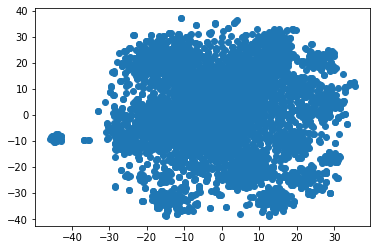

In [ ]:
plt.scatter(X_embedded[:,0],X_embedded[:,1])

In [ ]:
!git clone "https://github.com/anoopkunchukuttan/indic_nlp_library"
!git clone https://github.com/anoopkunchukuttan/indic_nlp_resources.git
!pip install Morfessor
# The path to the local git repo for Indic NLP library
INDIC_NLP_LIB_HOME=r"/content/indic_nlp_library"

# The path to the local git repo for Indic NLP Resources
INDIC_NLP_RESOURCES="/content/indic_nlp_resources"
import sys
sys.path.append(r'{}'.format(INDIC_NLP_LIB_HOME))
from indicnlp import common
common.set_resources_path(INDIC_NLP_RESOURCES)
from indicnlp import loader
from numpy import dot
from numpy.linalg import norm
from gensim.models import Word2Vec
import numpy as np
import time
from indicnlp.tokenize import indic_tokenize

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/hi.zip"

Mounted at /content/drive
Archive:  /content/drive/MyDrive/hi.zip
   creating: hi/
  inflating: hi/hi-train.csv         
  inflating: hi/hi-test.csv          


In [ ]:
import pandas as pd
import re
from sklearn import preprocessing

dataframe=pd.read_csv("./hi/hi-train.csv",header=None)

labels=dataframe[0].values
le = preprocessing.LabelEncoder()
le.fit(labels)
labels=le.transform(labels)
true_labels=np.array(labels)


def create_data(dataframe):

    data={}
    doc_id=0
    for category,text in zip(dataframe[0].values,dataframe[1].values):
        data[doc_id]={}
        data[doc_id]['text']=text
        data[doc_id]['category']=category
        doc_id+=1
    p = re.compile(r'[^\u0900-\u097F\n]')
    for key in data:
        text = data[key]['text']
        text = re.sub("\s\s+", " ", text)
        text = text.replace("(बीबीसी हिन्दी के एंड्रॉएड ऐप के लिए यहां क्लिक करें. आप हमें फ़ेसबुक और ट्विटर पर भी फ़ॉलो कर सकते हैं.)","")
        text = text.replace("(बीबीसी हिन्दी के एंड्रॉएड ऐप के लिए यहां क्लिक करें. आप हमें फ़ेसबुक और ट्विटर पर भी फ़ॉलो कर सकते हैं)","")
        text = text.replace("(बीबीसी हिंदी का एंड्रॉयड मोबाइल ऐप डाउनलोड करने के लिए क्लिक करें. आप ख़बरें पढ़ने और अपनी राय देने के लिए हमारे फ़ेसबुक पन्ने पर भी आ सकते हैं और ट्विटर पर फ़ॉलो भी कर सकते हैं.)","")
        text = p.sub(' ', text)
        text = re.sub("\s\s+", " ", text)
        data[key]['text']=text

    return data


,0,1
0,india,मेट्रो की इस लाइन के चलने से दक्षिणी दिल्ली से...
1,pakistan,नेटिजन यानि इंटरनेट पर सक्रिय नागरिक अब ट्विटर...
2,news,इसमें एक फ़्लाइट एटेनडेंट की मदद की गुहार है औ...
3,india,"प्रतीक खुलेपन का, आज़ाद ख्याली का और भीड़ से अ..."
4,india,ख़ासकर पिछले 10 साल तक प्रधानमंत्री रहे मनमोहन...


In [ ]:
categories=list(set(dataframe[0].values))
print(categories)

['sport', 'institutional', 'multimedia', 'entertainment', 'science', 'business', 'international', 'learningenglish', 'india', 'southasia', 'social', 'pakistan', 'china', 'news']


In [ ]:
for key in list(data.keys())[:10]:
    print(key,data[key])

0 {'text': 'मेट्रो की इस लाइन के चलने से दक्षिणी दिल्ली से नोएडा जाने का समय काफी कम हो जाएगा और यात्रियों को राजीव चौक या मंडी हाउस से होकर नहीं जाना पड़ेगा.लेकिन, यह मजेंटा लाइन इसलिए भी महत्वपूर्ण है क्योंकि इस पर ड्राइवलैस यानी बिना ड्राइवर वाली मेट्रो चलाने की योजना है. ऐसा भारत में पहली बार होगा जब कोई मेट्रो बिना ड्राइवर के चलाई जाएगी. मेट्रो के तीसरे फेज में भारत में पहली बार ड्राइवरलेस तकनीक आएगी लेकिन दुनिया भर में कई देशों में ड्राइवरलेस मेट्रो पहले से ही चलती हैं. इन देशों में ड्राइवरलेस मेट्रो सफल भी रही हैं. दक्षिण कोरिया की राजधानी सोल में ड्राइवलेस ट्रेन कामयाबी से चल रही है. ये मेट्रो ज़मीन के नीचे चलती है इसमें ड्राइवर का केबिन भी नहीं होता है. यूरोप में डेनमार्क, स्पेन, इटली, फ्रांस, जर्मनी, हंगरी, स्विट्जरलैंड और ब्रिटेन में भी ड्राइवरलैस मेट्रो चलती है. इन देशों में एक से ज़्यादा शहरों में भी ऐसी मेट्रो चलाई जाती है. इनके अलावा अमेरिका और कनाडा में भी ड्राइवरलेस ट्रेन चलती है. वहीं, ब्राजील, पेरू और चाइल में भी इस तरह की मेट्रो काफ़ी पहले आ चुकी है. भारत के पड़ोसी 

In [ ]:
import re


In [ ]:
hindi_vocab={}
idx=0
for key in data:
    text = data[key]['text']
    words=indic_tokenize.trivial_tokenize(text)
    words=set([word.replace("\u200d","") for word in words])
    for word in list(words):
        if len(word)>2:
            if hindi_vocab.get(word,0):
                hindi_vocab[word]['freq']=1+hindi_vocab[word]['freq']
                hindi_vocab[word]['posting'].add(key)
            else:
                hindi_vocab[word]={}
                hindi_vocab[word]['freq']=1
                hindi_vocab[word]['idx']=idx
                hindi_vocab[word]['posting']={key}
                idx+=1

In [ ]:
print(len(hindi_vocab))

48594


In [ ]:
delete = []
for key in hindi_vocab:
    if hindi_vocab[key]['freq'] < 2:
        delete.append(key)
for key in delete:
    del hindi_vocab[key]

In [ ]:
idx=0
for word in hindi_vocab:
    hindi_vocab[word]['plength']=len(hindi_vocab[word]['posting'])
    hindi_vocab[word]['idx']=idx
    idx+=1

In [ ]:
print(len(hindi_vocab))
for key in list(hindi_vocab)[:100]:
    print(key,hindi_vocab[key])

In [ ]:
import pickle
with open('hindi_vocab.pkl','wb') as f:
    pickle.dump(hindi_vocab,f)

In [ ]:
# import sys
# from indicnlp import common
# import gensim
# from numpy import dot
# from numpy.linalg import norm
# from gensim.models import Word2Vec
# import numpy as np
# import time

# INDIC_NLP_LIB_HOME=r"indic_nlp_library"
# INDIC_NLP_RESOURCES=r"indic_nlp_resources"
# sys.path.append(r'{}\src'.format(INDIC_NLP_LIB_HOME))
# common.set_resources_path(INDIC_NLP_RESOURCES)

# from indicnlp.tokenize import indic_tokenize

In [ ]:
# emb_type="fasttext"
# path="./hi/50/"+emb_type+"/hi-d50-m2-"+emb_type+".model"
# model = Word2Vec.load(path)

In [ ]:
# start_time = time.time()
# doc_vector=np.zeros(50,dtype=float)
# token_size=0
# for key in data:
#     tokens=indic_tokenize.trivial_tokenize(data[key]['text'])
#     tokens=set([token.replace("\u200d","") for token in tokens])
#     token_size=len(tokens)
#     for token in list(tokens):
#         doc_vector+=model.wv[token]

#     doc_vector=doc_vector/len(tokens)
#     if np.linalg.norm(doc_vector)!=0:
#         norm_doc_vector = doc_vector / np.linalg.norm(doc_vector)
#     else:
#         norm_doc_vector = doc_vector
#     data[key]['avg_emb']=norm_doc_vector
# print(str(round(time.time() - start_time,2))+" Seconds")

In [ ]:
for key in list(data.keys())[10:20]:
    print(key,data[key])

10 {'text': 'कुछ विशेषज्ञ कह रहे हैं कि उनके इंटरव्यू के बाद भाजपा का हौसला और भी बुलंद हो गया है कुछ अन्य विश्लेषणों में ये कहा जा रहा है कि राहुल गांधी के कारण कांग्रेस की अगले आम चुनाव में हार यक़ीनी है कुछ तो यहाँ तक कह रहे हैं कि राहुल गांधी कांग्रेस पार्टी के लिए बोझ साबित हो रहे हैं ट्विटर और फेसबुक जैसे सोशल मीडिया में उनके इंटरव्यू पर मज़ाक़ उड़ाया जा रहा है जो राहुल गांधी से थोड़ी बहुत सहानुभूति दिखा रहे हैं उनका कहना है कि वह नरेंद्र मोदी और भाजपा के प्रति आक्रामक रुख़ अख्तियार करने से चूक गए राहुल गांधी के इंटरव्यू पर क्या बोला सोशल मीडिया कुल मिलाकर यह नतीजा निकाला जा रहा है कि इंटरव्यू से पहले आगामी आम चुनाव में कांग्रेस की हार लगभग तय थी लेकिन इंटरव्यू के बाद ये निश्चित है इनमें से अधिकतर वही राजनीतिक विश्लेषक ऐसी टिप्पणियाँ कर रहे हैं जो दिल्ली विधानसभा चुनाव से पहले केजरीवाल की आम आदमी पार्टी को पाँच या छह सीटों से अधिक देने को तैयार नहीं थे इसका मतलब यह नहीं कि वे सभी ग़लत हैं ऐसा संभव है कि उनकी बात सच साबित हो लेकिन चुनाव में अभी कुछ महीने बाक़ी हैं और इस दौरान हाला

In [ ]:
with open('hindi_vocab.pkl','rb') as f:
    hindi_vocab=pickle.load(f)

In [ ]:
from collections import Counter
tf_idf = {}
num_doc=len(data)
for key in data:
    words = indic_tokenize.trivial_tokenize(data[key]['text'])
    words = [word.replace("\u200d","") for word in words]
    counter = Counter(words)
    words_count = len(words)
    for word in np.unique(words):
        if hindi_vocab.get(word,0):
            tf = counter[word]/words_count
            df = hindi_vocab[word]['plength']
            idf = np.log((num_doc+1)/(df+1))
            tf_idf[key,word] = round(tf*idf,5)

vocab=list(hindi_vocab.keys())
vocab_size=len(vocab)
Document_vector = np.zeros((num_doc, vocab_size))
for i in tf_idf:
    index = hindi_vocab[i[1]]['idx']
    Document_vector[i[0]][index] = tf_idf[i]

In [ ]:
print(Document_vector.shape)
print(Document_vector[:10])

(3467, 23103)
[[0.01229 0.01734 0.00166 ... 0.      0.      0.     ]
 [0.      0.      0.      ... 0.      0.      0.     ]
 [0.      0.      0.      ... 0.      0.      0.     ]
 ...
 [0.      0.      0.00617 ... 0.      0.      0.     ]
 [0.      0.      0.00159 ... 0.      0.      0.     ]
 [0.      0.      0.      ... 0.      0.      0.     ]]


In [ ]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
import numpy as np

In [ ]:
# Truncated SVD with randomised algorithm
matrix=csr_matrix(Document_vector)
svd = TruncatedSVD(n_components=25, n_iter=50, random_state=42)
random_DV=svd.fit_transform(matrix)
print(random_DV.shape)

(3467, 25)


In [ ]:
print(len(random_DV[0]))

300


In [ ]:
# Truncated SVD with arpack algorithm
matrix=csr_matrix(Document_vector)
svd = TruncatedSVD(n_components=300, n_iter=10, random_state=42,algorithm='arpack')
arpack_DV=svd.fit_transform(matrix)
print(arpack_DV.shape)

(3467, 300)


In [ ]:
print(arpack_DV[0])

In [ ]:
dataframe.head()

,0,1
0,india,मेट्रो की इस लाइन के चलने से दक्षिणी दिल्ली से...
1,pakistan,नेटिजन यानि इंटरनेट पर सक्रिय नागरिक अब ट्विटर...
2,news,इसमें एक फ़्लाइट एटेनडेंट की मदद की गुहार है औ...
3,india,"प्रतीक खुलेपन का, आज़ाद ख्याली का और भीड़ से अ..."
4,india,ख़ासकर पिछले 10 साल तक प्रधानमंत्री रहे मनमोहन...


3467
[3 9 8 ... 8 2 2]
14


In [ ]:
from sklearn.cluster import KMeans
import numpy as np
kmeans_random_DV = KMeans(n_clusters=14, random_state=0,algorithm='full',n_init=20,max_iter=500).fit(random_DV)
#kmeans_arpack_DV = KMeans(n_clusters=14, random_state=0).fit(arpack_DV)

In [ ]:
predicted_labels=kmeans_random_DV.labels_
len(kmeans_random_DV.cluster_centers_)

14

In [ ]:
from sklearn.cluster import DBSCAN
X = np.array([[1, 2], [2, 2], [2, 3],[8, 7], [8, 8], [25, 80]])
clustering = DBSCAN(eps=0.03, min_samples=4).fit(random_DV)
predicted_labels=clustering.labels_
print(predicted_labels)
# rand_score=metrics.rand_score(true_labels, predicted_labels)
# mutual_score=metrics.mutual_info_score(true_labels, predicted_labels)
# homo_score=metrics.homogeneity_score(true_labels, predicted_labels)
# complete_score=metrics.completeness_score(true_labels, predicted_labels)
# v_score=metrics.v_measure_score(true_labels, predicted_labels)
# fm_score=metrics.fowlkes_mallows_score(true_labels, predicted_labels)
# silhoutte_score=metrics.silhouette_score(random_DV, predicted_labels, metric='euclidean')
# calinski_score=metrics.calinski_harabasz_score(random_DV, predicted_labels)
# davies_score=davies_bouldin_score(random_DV, labels)
# print("rand_Score: ", rand_score)
# print("mutual_score: ",mutual_score)
# print("homo_score: ",homo_score)
# print("completeness_score: ",complete_score)
# print("V-score: ",v_score)
# print("fowlkes mallows: ",fm_score)
# print("silhoutte score: ",silhoutte_score)
# print("calinski_score: ",calinski_score)
# print("davies score: ",davies_score)

[-1 -1 -1 ... -1 -1 -1]


# Evaluation Metric API

# Kmeans API

# Document embedding **using** TF-IDF

In [ ]:
corpus=[]
for key in data:
    corpus.append(data[key]['text'])

In [ ]:
len(corpus)

3467

In [ ]:

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

import logging
from optparse import OptionParser
import sys
from time import time

import numpy as np
from sklearn.cluster import Birch

# labels = dataset.target
# true_k = np.unique(labels).shape[0]

# print("Extracting features from the training dataset using a sparse vectorizer")

# hasher = HashingVectorizer(
#             n_features=opts.n_features,
#             stop_words="english",
#             alternate_sign=False,
#             norm=None,
#         )

# vectorizer = make_pipeline(hasher, TfidfTransformer())
#     else:
#         vectorizer = HashingVectorizer(
#             n_features=opts.n_features,
#             stop_words="english",
#             alternate_sign=False,
#             norm="l2",
#         )
# else:


print("n_samples: %d, n_features: %d" % X.shape)
print()



explained_variance = svd.explained_variance_ratio_.sum()
print(
    "Explained variance of the SVD step: {}%".format(int(explained_variance * 100))
)

print()


# if opts.minibatch:
#     km = MiniBatchKMeans(
#         n_clusters=true_k,
#         init="k-means++",
#         n_init=1,
#         init_size=1000,
#         batch_size=1000,
#         verbose=opts.verbose,
#     )
# else:
# km = KMeans(
#     n_clusters=14,
#     init="k-means++",
#     max_iter=100,
#     n_init=10,
# )



print("Clustering sparse data with %s" % km)
km.fit(X)
print()
print("rand_score: %0.3f" % metrics.rand_score(true_labels, km.labels_))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(true_labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(true_labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(true_labels, km.labels_))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(true_labels, km.labels_))
print(
    "Silhouette Coefficient: %0.3f"
    % metrics.silhouette_score(X, km.labels_, sample_size=1000)
)

print()

# if opts.n_components:
original_space_centroids = svd.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
# else:
#     order_centroids = km.cluster_centers_.argsort()[:, ::-1]

terms = vectorizer.get_feature_names_out()
for i in range(14):
    print("Cluster %d:" % i, end="")
    for ind in order_centroids[i, :10]:
        print(" %s" % terms[ind], end="")
    print()

n_samples: 3467, n_features: 300

Explained variance of the SVD step: 62%

Clustering sparse data with KMeans(max_iter=100, n_clusters=14)

rand_score: 0.714
Homogeneity: 0.228
Completeness: 0.170
V-measure: 0.195
Adjusted Rand-Index: 0.069
Silhouette Coefficient: 0.021

Cluster 0: और कर पर कप रह इस एक नह रत अपन
Cluster 1: और पर कर इस एक मल उन कह गय रह
Cluster 2: और पर कर नह एक रह इस उन उनक हम
Cluster 3: हमल चरमप और पर कर एक इस गए रह धम
Cluster 4: बच और पर कर इस एक रह नह कह यह
Cluster 5: पन और कर पर इस एक इट रह करन सकत
Cluster 6: अमर और ओब पर रपत कर इस कह रह नह
Cluster 7: और पर इस कर एक रह यह गय तर रत
Cluster 8: इसर इल लस और पर हमल हम शलम कर कह
Cluster 9: और सरक पर कर इस कह रत रह नह उन
Cluster 10: रन ओवर बन आउट और पर बल रत कर छक
Cluster 11: जप और दव पर कर रह नह कह जनत दल
Cluster 12: ओल पदक वर रत और इनल पर कर टर रजत
Cluster 13: सलम और पर कर रह नह इस एक उन रत


In [ ]:
!ls

# Gensim based document embeddings

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
!unzip "/content/drive/MyDrive/CorpusDicts.zip"

Mounted at /content/drive/
Archive:  /content/drive/MyDrive/CorpusDicts.zip
  inflating: banglaDict.pkl          
  inflating: banglaDictNoStopwords.pkl  
  inflating: hindiDict.pkl           
  inflating: hindiDictNoStopwords.pkl  
  inflating: tamilDict.pkl           
  inflating: tamilDictNoStopwords.pkl  


In [ ]:
!git clone "https://github.com/anoopkunchukuttan/indic_nlp_library"
!git clone https://github.com/anoopkunchukuttan/indic_nlp_resources.git
!pip install Morfessor
INDIC_NLP_LIB_HOME=r"/content/indic_nlp_library"
INDIC_NLP_RESOURCES="/content/indic_nlp_resources"
import sys
sys.path.append(r'{}'.format(INDIC_NLP_LIB_HOME))
from indicnlp import common
common.set_resources_path(INDIC_NLP_RESOURCES)
from indicnlp import loader
from numpy import dot
from numpy.linalg import norm
from gensim.models import Word2Vec
import numpy as np
import time
from indicnlp.tokenize import indic_tokenize
import pandas as pd
import re
from sklearn import preprocessing
from collections import defaultdict
from gensim import corpora
from gensim import models
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import Birch,DBSCAN
from sklearn.mixture import GaussianMixture

Cloning into 'indic_nlp_library'...
remote: Enumerating objects: 1325, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 1325 (delta 91), reused 82 (delta 82), pack-reused 1218
Receiving objects: 100% (1325/1325), 9.55 MiB | 8.91 MiB/s, done.
Resolving deltas: 100% (701/701), done.
Cloning into 'indic_nlp_resources'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 139 (delta 2), reused 2 (delta 0), pack-reused 126
Receiving objects: 100% (139/139), 149.77 MiB | 29.51 MiB/s, done.
Resolving deltas: 100% (53/53), done.
Checking out files: 100% (28/28), done.


In [ ]:
import pickle


In [ ]:

#dataframe=pd.read_csv("./hi/hi-train.csv",header=None)
with open('hindiDictNoStopwords.pkl','rb') as f:
    data=pickle.load(f)

labels = []
for key in data:
    labels.append(data[key]['category'])
le = preprocessing.LabelEncoder()
le.fit(labels)
labels=le.transform(labels)
true_labels=np.array(labels)


# def create_data(dataframe):

#     data={}
#     doc_id=0
#     for category,text in zip(dataframe[0].values,dataframe[1].values):
#         data[doc_id]={}
#         data[doc_id]['text']=text
#         data[doc_id]['category']=category
#         doc_id+=1
#     p = re.compile(r'[^\u0900-\u097F\n]')
#     for key in data:
#         text = data[key]['text']
#         text = re.sub("\s\s+", " ", text)
#         text = text.replace("(बीबीसी हिन्दी के एंड्रॉएड ऐप के लिए यहां क्लिक करें. आप हमें फ़ेसबुक और ट्विटर पर भी फ़ॉलो कर सकते हैं.)","")
#         text = text.replace("(बीबीसी हिन्दी के एंड्रॉएड ऐप के लिए यहां क्लिक करें. आप हमें फ़ेसबुक और ट्विटर पर भी फ़ॉलो कर सकते हैं)","")
#         text = text.replace("(बीबीसी हिंदी का एंड्रॉयड मोबाइल ऐप डाउनलोड करने के लिए क्लिक करें. आप ख़बरें पढ़ने और अपनी राय देने के लिए हमारे फ़ेसबुक पन्ने पर भी आ सकते हैं और ट्विटर पर फ़ॉलो भी कर सकते हैं.)","")
#         text = p.sub(' ', text)
#         text = re.sub("\s\s+", " ", text)
#         data[key]['text']=text

#     return data


In [ ]:
print(set(true_labels))

{0, 1, 2, 3, 4, 5, 6, 7, 8}


In [ ]:

def apply_kmeans(doc_vector):

        kmeans = KMeans(n_clusters=8, random_state=0,algorithm='full',n_init=1,max_iter=100).fit(doc_vector)
        predicted_labels=kmeans.labels_

        return predicted_labels

In [ ]:

def apply_birch(doc_vector):

    brc = Birch(n_clusters=8).fit(doc_vector)
    predicted_labels=brc.labels_

    return predicted_labels

In [ ]:
def apply_GMM(doc_vector):

    gm = GaussianMixture(n_components=8, random_state=0).fit(doc_vector)
    predicted_labels=gm.predict(doc_vector)
    return predicted_labels

In [ ]:

def evaluate(true_labels,predicted_labels,doc_vector):

    rand_score=metrics.rand_score(true_labels, predicted_labels)
    mutual_score=metrics.mutual_info_score(true_labels, predicted_labels)
    homo_score=metrics.homogeneity_score(true_labels, predicted_labels)
    complete_score=metrics.completeness_score(true_labels, predicted_labels)
    v_score=metrics.v_measure_score(true_labels, predicted_labels)
    fm_score=metrics.fowlkes_mallows_score(true_labels, predicted_labels)
    silhoutte_score=metrics.silhouette_score(doc_vector, predicted_labels, metric='euclidean')
    calinski_score=metrics.calinski_harabasz_score(doc_vector, predicted_labels)
    davies_score=davies_bouldin_score(doc_vector, labels)
    print("rand_Score: ", rand_score)
    print("mutual_score: ",mutual_score)
    print("homo_score: ",homo_score)
    print("completeness_score: ",complete_score)
    print("V-score: ",v_score)
    print("fowlkes mallows: ",fm_score)
    print("silhoutte score: ",silhoutte_score)
    print("calinski_score: ",calinski_score)
    print("davies score: ",davies_score)

    return [rand_score,mutual_score,homo_score,complete_score,v_score,fm_score,silhoutte_score, calinski_score,davies_score]

In [ ]:
def TF_IDF(data):
    
    corpus=[]
    for key in data:
        corpus.append(data[key]['text'])

    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(corpus)
    svd = TruncatedSVD(30)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    return X

In [ ]:
def get_corpus_tfidf(data):

    texts = [[word for word in indic_tokenize.trivial_tokenize(data[key]['text'])] for key in data]

    frequency = defaultdict(int)
    for text in texts:
        for token in text:
            frequency[token] += 1

    texts = [[token for token in text if frequency[token]>1] for text in texts]

    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]

    return corpus_tfidf,dictionary

In [ ]:
def train_LSA(corpus_tfidf,dictionary):

    lsi_model = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=30)
    corpus_lsi = lsi_model[corpus_tfidf]
    doc_vector=[]
    for embedding in corpus_lsi:
        vector=[]
        for id,value in embedding:
            vector.append(value)
        doc_vector.append(vector)
    
    doc_vector=np.array(doc_vector) 

    return doc_vector

In [ ]:


def train_RP(corpus_tfidf):

    model = models.RpModel(corpus_tfidf, num_topics=30)
    corpus_lsi = model[corpus_tfidf]
    doc_vector=[]
    for embedding in corpus_lsi:
        vector=[]
        for id,value in embedding:
            vector.append(value)
        doc_vector.append(vector)
    
    doc_vector=np.array(doc_vector) 

    return doc_vector

In [ ]:
def train_LDA(corpus_tfidf,dictionary,dim):
    
    lda_model = models.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=dim)
    corpus_lda = lda_model[corpus_tfidf]
    doc_vector=[]
    for doc in corpus_lda:
        vector=[0]*dim
        for idx,value in doc:
            vector[idx]=value
        doc_vector.append(vector)
    
    dim-=10
    svd = TruncatedSVD(dim)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    doc_vector = lsa.fit_transform(doc_vector)

    doc_vector=np.array(doc_vector) 

    return doc_vector

In [ ]:
def KMEANS_results(data):


    print(" ***************** KMEANS Clustering Model *********************")
    print()
    #data=create_data(dataframe)

    print(" =============================== TF-IDF based =====================================")
    print()
    doc_vector=TF_IDF(data)
    predicted_labels=apply_kmeans(doc_vector)
    scores=evaluate(true_labels,predicted_labels,doc_vector)

    corpus_tfidf,dictionary=get_corpus_tfidf(data)
    print("================================ Traning LSA model ================================")
    print()
    doc_vector=train_LSA(corpus_tfidf,dictionary)
    predicted_labels=apply_kmeans(doc_vector)
    scores=evaluate(true_labels,predicted_labels,doc_vector)
    print("================================ Traning Random projection model ================================")
    print()
    doc_vector=train_RP(corpus_tfidf)
    predicted_labels=apply_kmeans(doc_vector)
    scores=evaluate(true_labels,predicted_labels,doc_vector)
    print("================================ Traning LDA model ================================")
    print()
    doc_vector=train_LDA(corpus_tfidf,dictionary,dim=40)
    predicted_labels=apply_kmeans(doc_vector)
    scores=evaluate(true_labels,predicted_labels,doc_vector)

In [ ]:
def BIRCH_results(data):

    print(" ***************** BIRCH Clustering Model *********************")
    print()
    #data=create_data(dataframe)
    print(" =============================== TF-IDF based =====================================")
    print()
    doc_vector=TF_IDF(data)
    predicted_labels=apply_birch(doc_vector)
    scores=evaluate(true_labels,predicted_labels,doc_vector)

    corpus_tfidf,dictionary=get_corpus_tfidf(data)
    print("================================ Traning LSA model ================================")
    print()
    doc_vector=train_LSA(corpus_tfidf,dictionary)
    predicted_labels=apply_birch(doc_vector)
    try:
        scores=evaluate(true_labels,predicted_labels,doc_vector)
    except:
        print("can find clusters")
    print("================================ Traning Random projection model ================================")
    print()
    doc_vector=train_RP(corpus_tfidf)
    predicted_labels=apply_birch(doc_vector)
    scores=evaluate(true_labels,predicted_labels,doc_vector)
    print("================================ Traning LDA model ================================")
    print()
    doc_vector=train_LDA(corpus_tfidf,dictionary,dim=40)
    predicted_labels=apply_birch(doc_vector)
    scores=evaluate(true_labels,predicted_labels,doc_vector)

In [ ]:
def GMM_results(data):

    print(" ***************** GMM Clustering Model *********************")
    print()
    #data=create_data(dataframe)
    print(" =============================== TF-IDF based =====================================")
    print()
    doc_vector=TF_IDF(data)
    predicted_labels=apply_GMM(doc_vector)
    scores=evaluate(true_labels,predicted_labels,doc_vector)

    corpus_tfidf,dictionary=get_corpus_tfidf(data)
    print("================================ Traning LSA model ================================")
    print()
    doc_vector=train_LSA(corpus_tfidf,dictionary)
    predicted_labels=apply_GMM(doc_vector)
    scores=evaluate(true_labels,predicted_labels,doc_vector)
    print("================================ Traning Random projection model ================================")
    print()
    doc_vector=train_RP(corpus_tfidf)
    predicted_labels=apply_GMM(doc_vector)
    scores=evaluate(true_labels,predicted_labels,doc_vector)
    print("================================ Traning LDA model ================================")
    print()
    doc_vector=train_LDA(corpus_tfidf,dictionary,dim=40)
    predicted_labels=apply_GMM(doc_vector)
    scores=evaluate(true_labels,predicted_labels,doc_vector)

In [ ]:
#KMEANS_results(data)
BIRCH_results(data)
#GMM_results(data)

 ***************** BIRCH Clustering Model *********************

 =============================== TF-IDF based =====================================

rand_Score:  0.693015719082973
mutual_score:  0.26488528432232067
homo_score:  0.16163044112474942
completeness_score:  0.13897104586092687
V-score:  0.14944670880579983
fowlkes mallows:  0.2913643871444454
silhoutte score:  0.04061513425767435
calinski_score:  113.12869885383091
davies score:  6.409159828834036
================================ Traning LSA model ================================



/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_birch.py:721: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (8). Decrease the threshold.
  ConvergenceWarning,


can find clusters
================================ Traning Random projection model ================================

rand_Score:  0.6716976911141885
mutual_score:  0.040815649306448
homo_score:  0.02490531483873134
completeness_score:  0.020596682897504034
V-score:  0.022547004426900216
fowlkes mallows:  0.20118869365330466
silhoutte score:  -0.0033574438703160916
calinski_score:  28.428732460906783
davies score:  14.294275731873277
================================ Traning LDA model ================================

rand_Score:  0.6163123010947796
mutual_score:  0.09652900400870976
homo_score:  0.058901065565708934
completeness_score:  0.06519972307533195
V-score:  0.061890552119443526
fowlkes mallows:  0.298690118418246
silhoutte score:  0.11848725894018221
calinski_score:  196.2525564923117
davies score:  12.2357094730101


In [ ]:
#https://github.com/eftekhar-hossain/Bengali-Document-Categorization